# Sampling

This notebook discusses sampling, from chapter 11 of Bishop's Pattern Recognition and Machine Learning.

## Inverse Transform Sampling
Sampling from $Uniform[0, 1]$ is easy (using a pseudo-random number generator). Before we discuss complex distributions, we must bridge the gap -- how do we sample from simple (nonuniform) distributions?

Inverse transform sampling allows us to sample from a distribution through the following steps:
1) Take a nonuniform distribution $p(y) = p(z)\left|\frac{dz}{dy}\right|$ where $z$ is uniformly distributed on $[0, 1]$, and $y = f(z)$

2) Find the cumulative density function $z = h(y) = \int_{-\infty}^y p(\widehat{y})\text{d}\widehat{y}$ to get a function mapping $Dom(p(y)) \mapsto [0, 1]$

3) Invert the cumulative density function $y = h^{-1}(z)$ to get a function mapping $[0, 1] \mapsto Dom(p(y))$

4) Generate samples from Uniform[0, 1] and pass them through $h^{-1}(z)$, which will then be distributed according to $p(y)$

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import pandas as pd

For example, let's take
$$p(y) = \lambda \exp(-\lambda y).$$
Here, the indefinite integral (whose lower limit is now 0 instead of $-\infty$) is
$$h(y) = 1-\exp(-\lambda y)$$
and then pass $z \sim Uniform[0, 1]$ through $h^{-1}$:
$$y = -\lambda^{-1}\ln(1-z)$$

In [98]:
p = lambda y, l: l*np.exp(-l*y)
h = lambda y, l: 1-np.exp(-l*y)
y = lambda z, l: -1/l * np.log(1-z)

/Users/kanyesthaker/Documents/projects/prml-notebooks/.env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Samples drawn from inverse transform'}, ylabel='Samples'>

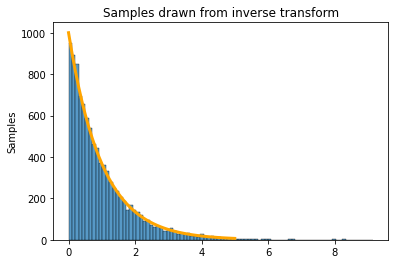

In [102]:
xs = np.linspace(0, 5)
ys = [p(x, 1) for x in xs]
zs = np.random.uniform(0, 1, 10000)
samples = [y(z, 1) for z in zs]
plt.ylabel("Samples")
plt.title("Samples drawn from inverse transform")
sns.lineplot(xs, [y*1000 for y in ys], color="orange", linewidth=3)
sns.histplot(data=sorted(samples), bins=90)

To sample from the Gaussian distribution, we use the Box-Muller method since the Gaussian inverse CDF is not well-defined. To do this, we uniformly select samples from a unit circle, after which we transform those samples (in polar form) to get our desired standard normal PDF.

/Users/kanyesthaker/Documents/projects/prml-notebooks/.env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kanyesthaker/Documents/projects/prml-notebooks/.env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

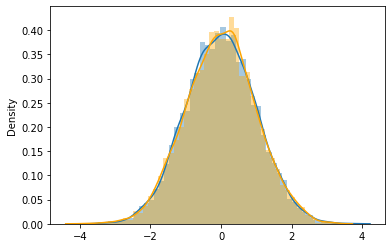

In [104]:
u1 = np.random.uniform(0, 1, 10000)
u2 = np.random.uniform(0, 1, 10000)
r2 = -2 * np.log(u1)
theta = 2 * np.pi * u2
z1 = np.sqrt(r2) * np.cos(theta)
z2 = np.sqrt(r2) * np.sin(theta)

sns.distplot(z1)
sns.distplot(z2, color="orange")

## Rejection Sampling

Complex distributions aren't always so easy to sample, and the inverse transform sampling method doesn't always have nice workarounds as in the standard normal case. Rejection sampling involves enveloping $p(z)$ in some more tractable distribution $q(z)$ (known as the *proposal distribution*) and rejecting all samples from $q(z)$ which are strictly greater than $p(z)$. Note that this works up to normalization, meaning that in reality we can only calculate a non-normalized equivalent $\widetilde{p}(z)$ and must scale our proposal distribution to $kq(z)$, where we must determine the value of $k$.

For example, let's take a mixture of Gaussians, i.e. $\mathcal{N}(3, 1) + \mathcal{N}(8, 2)$. We attempt to approximate this with a simple Gaussian, say $\mathcal{N}(5, 3)$ (which is easy to sample from based on the above discussion, the standard normal scaled by the new mean and variance). We find $k$ simply by finding the tightest envelope, i.e. by letting $k$ be $max(p(x)/q(x))$.

/Users/kanyesthaker/Documents/projects/prml-notebooks/.env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/kanyesthaker/Documents/projects/prml-notebooks/.env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

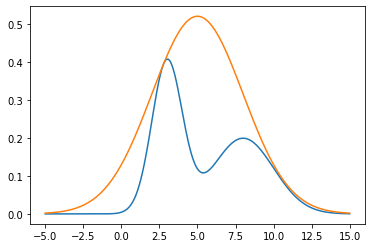

In [105]:
p = lambda x: st.norm.pdf(x, loc=3, scale=1) + st.norm.pdf(x, loc=8, scale=2)
xs = np.linspace(-5, 15, 1000)
pxs = [p(x) for x in xs]
q = lambda x: st.norm.pdf(x, loc=5, scale=3)
qxs = [q(x) for x in xs]
k = max([px/qx for px,qx in zip(pxs, qxs)])
kq = lambda x: k * q(x)
kqxs = [kq(x) for x in xs]
sns.lineplot(xs, pxs)
sns.lineplot(xs, kqxs)

The key with rejection sampling is drawing samples $z$ from $kq(x)$. We then also select a height for this sample, $u \sim Uniform[0, kq(x)]$. Now, we discard all points $(z, u)$ where $u > \widetilde{p}(x)$. The resulting accepted $z$ values will be representative of the true distribution $p$.

/Users/kanyesthaker/Documents/projects/prml-notebooks/.env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

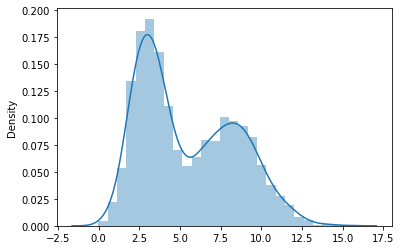

In [106]:
samples = []
for _ in range(10000):
    z = np.random.normal(5, 3)
    u = np.random.uniform(0, kq(z))
    if u <= p(z):
        samples.append(z)

sns.distplot(samples)